<a href="https://colab.research.google.com/github/carlsec/machine_learning/blob/master/Blood_Cell_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile

path = "/content/drive/MyDrive/dataset2-master.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

# Transfer Learning


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
tf.__version__

'2.3.0'

In [3]:
model_base = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
)

model_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [4]:
len(model_base.layers)

190

In [5]:
for layer in model_base.layers[:]:
  layer.trainable = True

In [6]:
x = model_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)
preds = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(inputs = model_base.input, outputs = preds)

# Model


In [7]:
base_dir = '/content/dataset2-master/images'

train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')
test_dir = os.path.join(base_dir, 'TEST_SIMPLE')

train_1_dir = os.path.join(train_dir, 'EOSINOPHIL') 
train_2_dir = os.path.join(train_dir, 'LYMPHOCYTE') 
train_3_dir = os.path.join(train_dir, 'MONOCYTE')
train_4_dir = os.path.join(train_dir, 'NEUTROPHIL')

validation_1_dir = os.path.join(validation_dir, 'EOSINOPHIL') 
validation_2_dir = os.path.join(validation_dir, 'LYMPHOCYTE') 
validation_3_dir = os.path.join(validation_dir, 'MONOCYTE')
validation_4_dir = os.path.join(validation_dir, 'NEUTROPHIL')

test_1_dir = os.path.join(test_dir, 'EOSINOPHIL') 
test_2_dir = os.path.join(test_dir, 'LYMPHOCYTE') 
test_3_dir = os.path.join(test_dir, 'MONOCYTE')
test_4_dir = os.path.join(test_dir, 'NEUTROPHIL')

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input,
                                   rotation_range = 180,
                                   width_shift_range = 0.6,
                                   height_shift_range = 0.6,
                                   shear_range = 0.6,
                                   zoom_range = 0.6,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.,
                                  preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    target_size = (224, 224))

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 64,
                                                          class_mode  = 'categorical',
                                                          shuffle = True,
                                                          target_size = (224, 224))

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                    batch_size  = 64,
                                                    class_mode  = 'categorical', 
                                                    target_size = (224, 224))

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [9]:
sample_training_images, train_labels = next(train_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

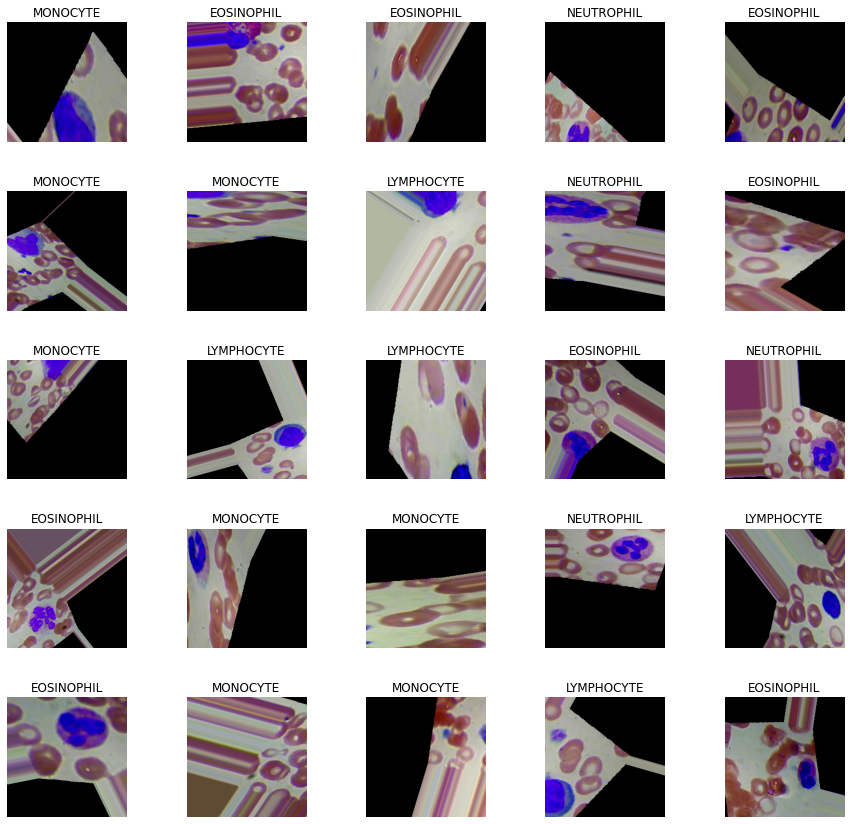

In [10]:
labels_names = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow((sample_training_images[i] * 255))
  label = np.argmax(train_labels[i])
  axes[i].set_title(labels_names[label])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [11]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(lr=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [12]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 15,
            verbose = 1)

Epoch 1/15
156/156 [==============================] - 152s 973ms/step - loss: 1.4016 - accuracy: 0.2563 - val_loss: 1.3906 - val_accuracy: 0.2493
Epoch 2/15
156/156 [==============================] - 150s 964ms/step - loss: 1.3123 - accuracy: 0.3377 - val_loss: 1.3988 - val_accuracy: 0.2505
Epoch 3/15
156/156 [==============================] - 150s 960ms/step - loss: 1.2281 - accuracy: 0.3974 - val_loss: 1.4035 - val_accuracy: 0.2493
Epoch 4/15
156/156 [==============================] - 150s 964ms/step - loss: 1.0966 - accuracy: 0.4916 - val_loss: 1.4230 - val_accuracy: 0.2493
Epoch 5/15
156/156 [==============================] - 150s 961ms/step - loss: 1.0177 - accuracy: 0.5126 - val_loss: 1.3909 - val_accuracy: 0.2509
Epoch 6/15
156/156 [==============================] - 150s 964ms/step - loss: 0.9349 - accuracy: 0.5244 - val_loss: 4.4605 - val_accuracy: 0.2803
Epoch 7/15
156/156 [==============================] - 150s 963ms/step - loss: 0.9209 - accuracy: 0.5344 - val_loss: 1.7443 -

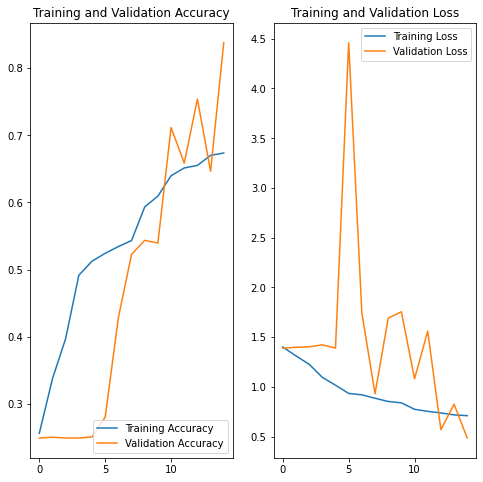

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
_, test_labels = next(test_generator)

In [22]:
predictions = model.predict(test_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

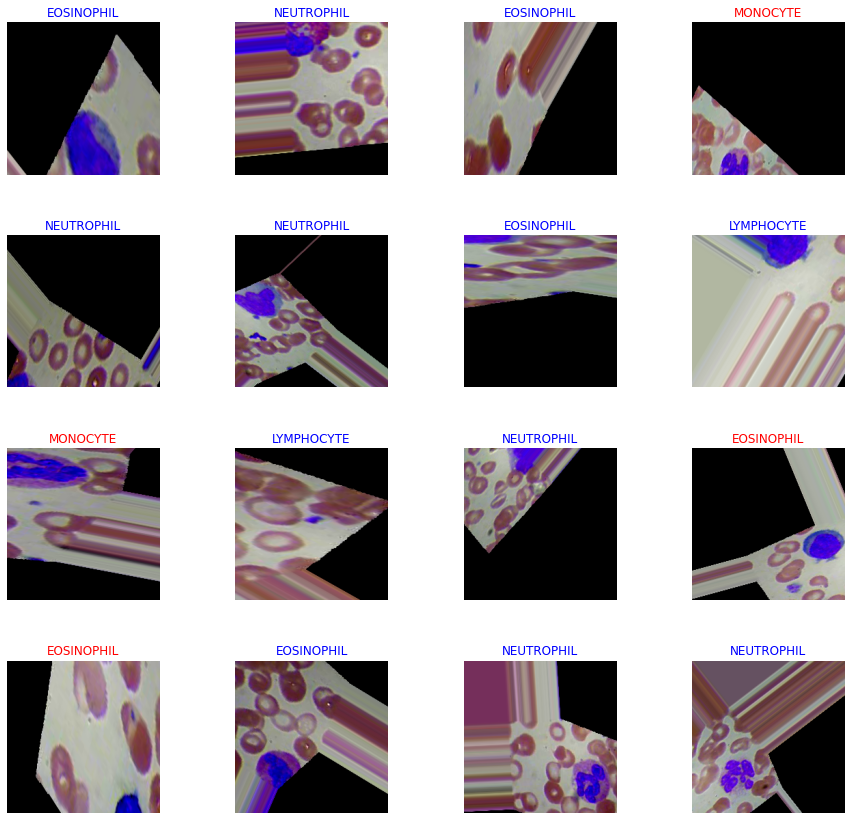

In [23]:
labels_names = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.ravel()
for i in np.arange(0, 16):
  axes[i].imshow((sample_training_images[i] * 255))
  label = np.argmax(test_labels[i])
  pred = np.argmax(predictions[i])
  col = 'blue' if label == pred else 'red'
  axes[i].set_title(labels_names[pred], color = col)
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)